In [33]:
# Author: Viviana Perls
# Collaborators: Kareem Ibrahim, Nicholas De La Cruz

#https://nycourts.gov/courts/nyc/housing/definitions.shtml#e
#https://www.nycourts.gov/courts/nyc/civil/ejectment.shtml

In [34]:
# Imports

import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import requests
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 

##Loading Datasets

In [35]:
# Eviction dataset from https://data.cityofnewyork.us/City-Government/Evictions/6z8x-wfk4
# Zip Code Breakdown dataset from https://data.cityofnewyork.us/City-Government/Zip-code-breakdowns/6bic-qvek

demographics_df = pd.read_csv('https://raw.githubusercontent.com/vperls000/csc44700/main/Zip_code_breakdowns.csv', \
                              usecols= ['JURISDICTION NAME','PERCENT FEMALE','PERCENT MALE','PERCENT PACIFIC ISLANDER', \
                                        'PERCENT HISPANIC LATINO','PERCENT AMERICAN INDIAN','PERCENT ASIAN NON HISPANIC', \
                                        'PERCENT WHITE NON HISPANIC','PERCENT BLACK NON HISPANIC','PERCENT OTHER ETHNICITY', \
                                        'PERCENT ETHNICITY UNKNOWN','PERCENT PERMANENT RESIDENT ALIEN','PERCENT US CITIZEN', \
                                        'PERCENT OTHER CITIZEN STATUS', 'PERCENT RECEIVES PUBLIC ASSISTANCE', \
                                        'PERCENT NRECEIVES PUBLIC ASSISTANCE'])
demographics_df.rename(columns={'JURISDICTION NAME' : 'zipcode', 'PERCENT AMERICAN INDIAN' : 'PERCENT INDIGENOUS'}, inplace=True)

In [36]:
# Get Evictions data and convert to DataFrame
evictions_df = pd.read_csv('https://raw.githubusercontent.com/vperls000/csc44700/main/Evictions.csv')
evictions_df.drop(labels=['Eviction Apartment Number','Court Index Number','Census Tract','BIN','BBL','Marshal First Name', \
                          'Marshal Last Name','Ejectment','Eviction/Legal Possession'],axis=1,inplace=True)
evictions_df.rename(columns={'Eviction Postcode' : 'zipcode'}, inplace=True)

In [37]:
evictions_df['Eviction Address'].value_counts().nlargest(10)

541 WEST 29TH STREET    71
40 RICHMAN PLAZA        56
20 RICHMAN PLAZA        54
30 RICHMAN PLAZA        41
10 RICHMAN PLAZA        40
645 WEST 44TH STREET    38
5030 BROADWAY           36
605 WEST 42ND STREET    33
220 SOUTH STREET        31
49-57 CROWN STREET      30
Name: Eviction Address, dtype: int64

## Merging and Tweaking Datasets

In [38]:
# Merge datasets to associate demographics with evictions
df = pd.merge(left=evictions_df, right=demographics_df, on='zipcode')


# Convert datatypes
df['Executed Date'] = pd.to_datetime(df['Executed Date'])
df['Year'] = pd.DatetimeIndex(df['Executed Date']).year
col = df.pop('Year')
df.insert(6, col.name, col)

df = df.astype({'zipcode' : str, 'Community Board' : str, 'Council District' : str, 'Year' : str})

# Change Percentages to Integers
for col in df:
  if 'PERCENT' in col:
    df[col] = df[col].apply(lambda x : x*100)


# Remove Unnecessary Rows & Columns
df = df[df['Residential/Commercial'].str.contains('Commercial')==False]
df = df.drop(['Eviction Address','Executed Date','Residential/Commercial'], axis=1)

df = df.dropna(subset=['Latitude','Longitude'])

ethnicities = ['PERCENT PACIFIC ISLANDER','PERCENT HISPANIC LATINO','PERCENT INDIGENOUS', 'PERCENT ASIAN NON HISPANIC', \
               'PERCENT WHITE NON HISPANIC','PERCENT BLACK NON HISPANIC','PERCENT OTHER ETHNICITY','PERCENT ETHNICITY UNKNOWN']
df['is all 0'] = 0
for col in ethnicities:
  df['is all 0'] = df['is all 0'] + df[col]
df = df[df['is all 0'] !=0]
df = df.drop(['is all 0'], axis=1)

## Visual Representations of Data

In [39]:
zips = pd.DataFrame(data=df['zipcode'].value_counts()).reset_index()
zips = zips.rename(columns ={'zipcode' : 'count', 'index' : 'zipcode'})

zipcode_geo_url = 'https://data.beta.nyc/dataset/3bf5fb73-edb5-4b05-bb29-7c95f4a727fc/resource/6df127b1-6d04-4bb7-b983-07402a2c3f90/download/f4129d9aa6dd4281bc98d0f701629b76nyczipcodetabulationareas.geojson'
res = requests.get(zipcode_geo_url)
zipcode_geo = json.loads(res.text)

fig = px.choropleth_mapbox(zips,
                           geojson=zipcode_geo,
                           locations='zipcode',
                           featureidkey="properties.postalCode",
                           color='count',
                           color_continuous_scale='bluered',
                           mapbox_style="carto-positron",
                           zoom=9, center={"lat": 40.75, "lon": -73.9},
                           opacity=0.7,
                           hover_name='zipcode',
                           title='Total Evictions per Zip',
                           width=700,
                           height=550
                           )
fig.show()

In [40]:
fig = px.choropleth_mapbox(df,
                           geojson=zipcode_geo,
                           locations='zipcode',
                           featureidkey="properties.postalCode",
                           color='PERCENT RECEIVES PUBLIC ASSISTANCE',
                           color_continuous_scale='inferno',
                           mapbox_style="carto-positron",
                           zoom=9, center={"lat": 40.75, "lon": -73.9},
                           opacity=0.7,
                           hover_name='zipcode',
                           hover_data=ethnicities,
                           title='Percent Receives Public Assistance per Zip',
                           width=700,
                           height=550
                           )
fig.show()

In [41]:
fig = px.choropleth_mapbox(df,
                           geojson=zipcode_geo,
                           locations='zipcode',
                           featureidkey="properties.postalCode",
                           color='PERCENT WHITE NON HISPANIC',
                           color_continuous_scale='inferno',
                           mapbox_style="carto-positron",
                           zoom=9, center={"lat": 40.75, "lon": -73.9},
                           opacity=0.7,
                           hover_name='zipcode',
                           hover_data=ethnicities,
                           title='Percent White Non Hispanic per Zip',
                           width=700,
                           height=550
                           )
fig.show()

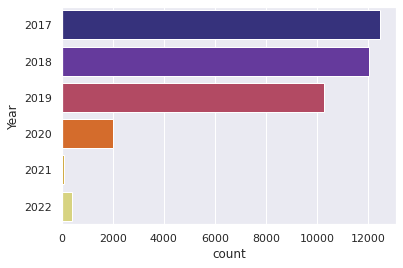

In [42]:
sns.set_theme(palette='CMRmap')
sns.countplot(y=df['Year'], order=['2017','2018','2019','2020','2021','2022'])

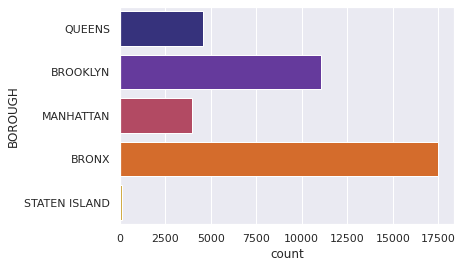

In [43]:
sns.countplot(y=df['BOROUGH'])

## Encoding Columns

In [44]:
# Encode certain columns

# Columns that could/should be encoded:
#   BOROUGH (5)
#   Community Board (18)
#   Council District (51)
#   NTA (191)
#   zipcode (174)

In [45]:
# One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=['BOROUGH'])

In [46]:
# Categorical Encoding
features = ['Community Board', 'Council District', 'NTA', 'zipcode']
for ft in features:
  le = LabelEncoder()
  if (str(df_encoded[ft].dtype) == 'object'):
    df_encoded[ft] = le.fit_transform(df_encoded[ft])

In [47]:
# Adding scaler to normalize categories within columns
# Since BOROUGH is one-hot encoded, I'll use the range [0,1] to make sure the numerical values
# are on about the same scale as the binary values in BOROUGH_ columns
features = ['Community Board', 'Council District', 'NTA', 'zipcode', 'Year', 'Latitude', 'Longitude', 'PERCENT FEMALE','PERCENT MALE', \
            'PERCENT PACIFIC ISLANDER', 'PERCENT HISPANIC LATINO','PERCENT INDIGENOUS','PERCENT ASIAN NON HISPANIC', \
            'PERCENT WHITE NON HISPANIC','PERCENT BLACK NON HISPANIC','PERCENT OTHER ETHNICITY', 'PERCENT ETHNICITY UNKNOWN', \
            'PERCENT PERMANENT RESIDENT ALIEN','PERCENT US CITIZEN', 'PERCENT OTHER CITIZEN STATUS', 'PERCENT RECEIVES PUBLIC ASSISTANCE', \
            'PERCENT NRECEIVES PUBLIC ASSISTANCE']
scaled_columns = df_encoded[features]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_columns = scaler.fit_transform(scaled_columns)

df_encoded[features] = scaled_columns

In [48]:
# Removing Year column since I only wanted to use it for visualizations
df_encoded = df_encoded.drop('Year', axis=1)

## K Means Clustering

In [49]:
labels = KMeans(n_clusters=5, random_state=0).fit_predict(df_encoded)
df['label'] = labels

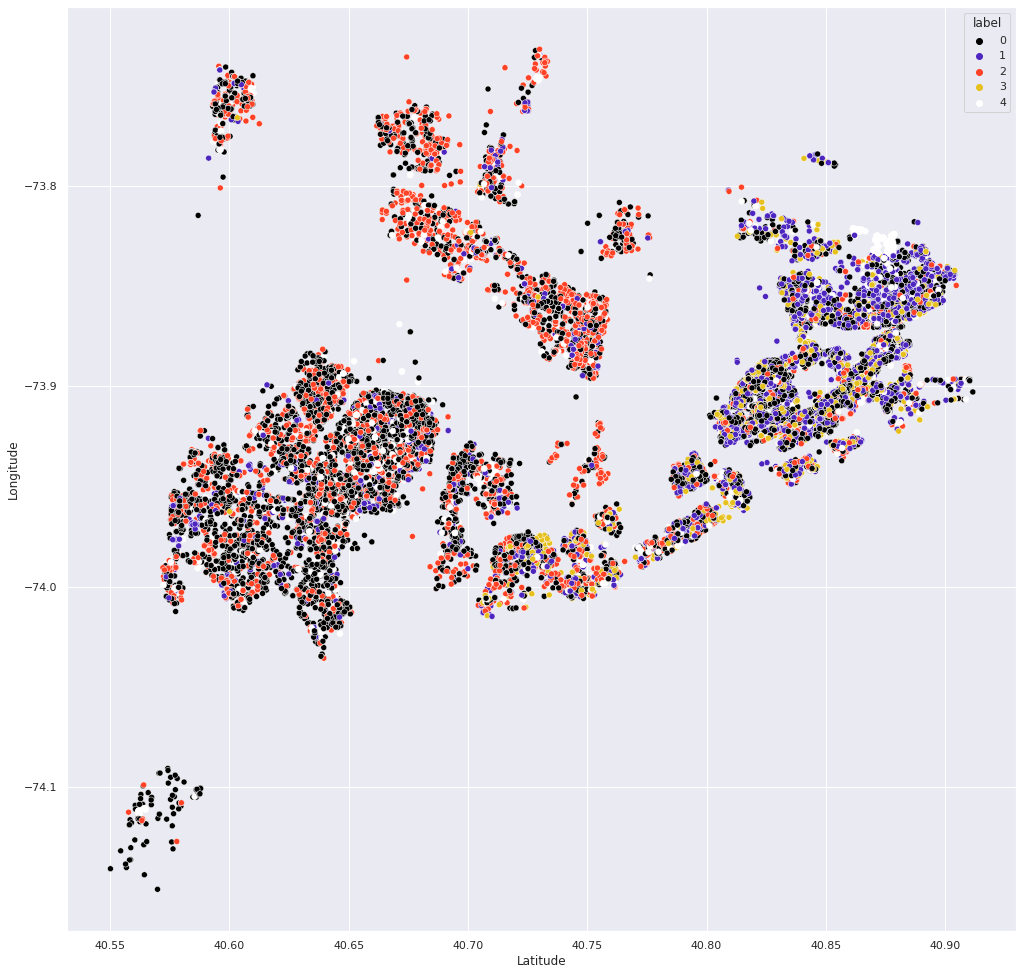

In [50]:
plt.figure(figsize=(17,17))
sns.scatterplot(x=df['Latitude'],y=df['Longitude'],hue=df['label'],data=df,legend='full',palette='CMRmap')

##Clusters plotted with respect to columns

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



17005.0    17005
7945.0      7945
6558.0      6558
3589.0      3589
2177.0      2177
Name: label count, dtype: int64


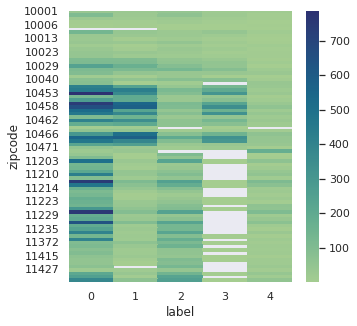

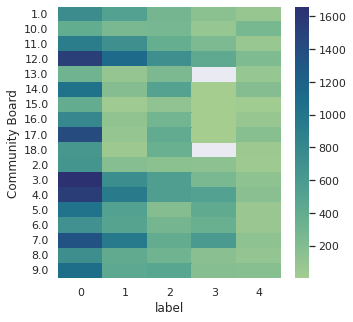

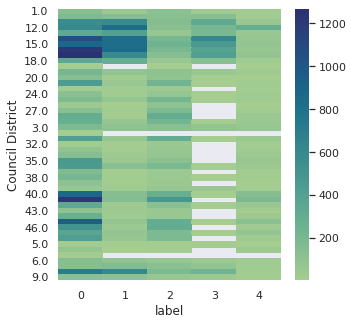

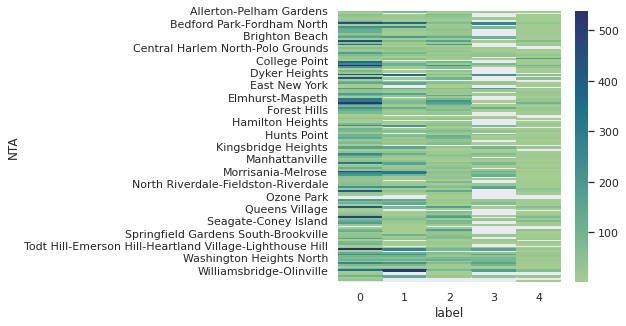

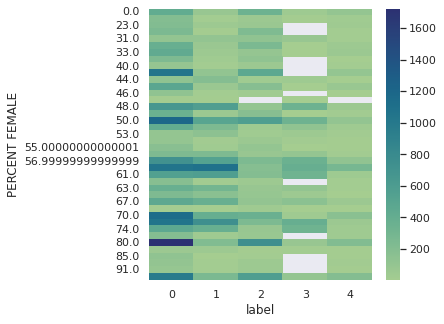

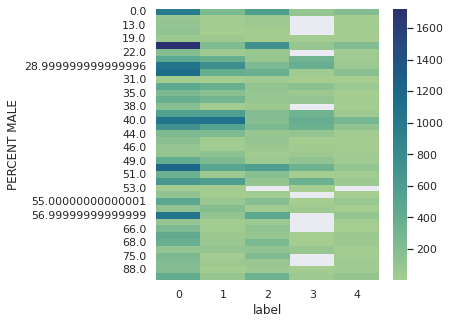

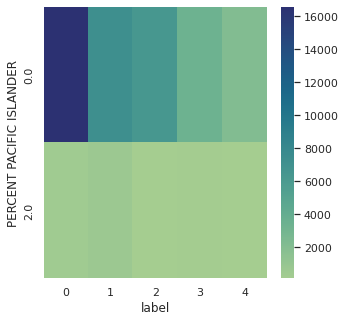

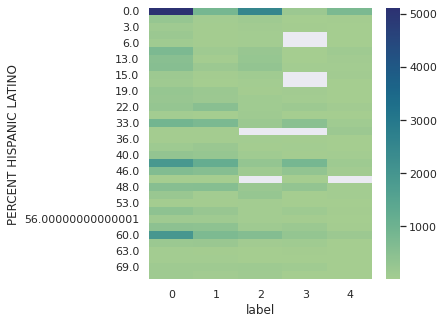

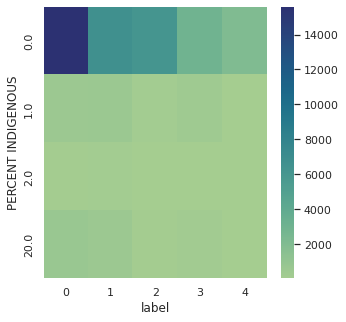

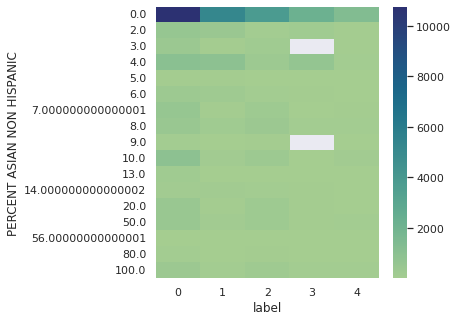

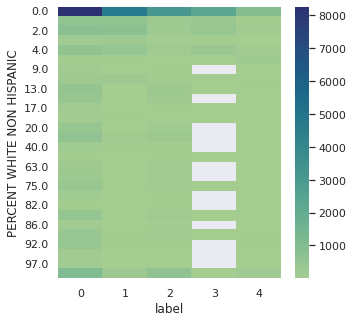

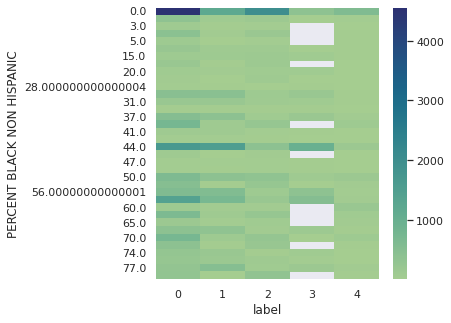

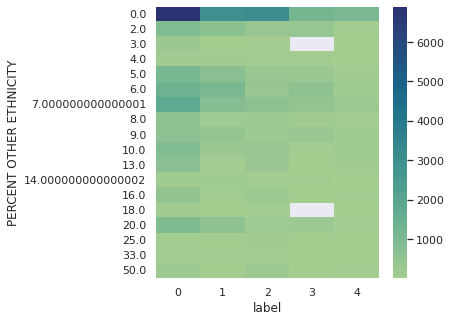

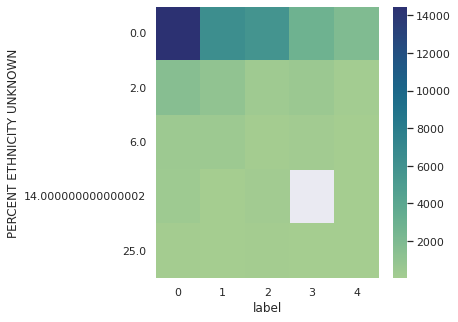

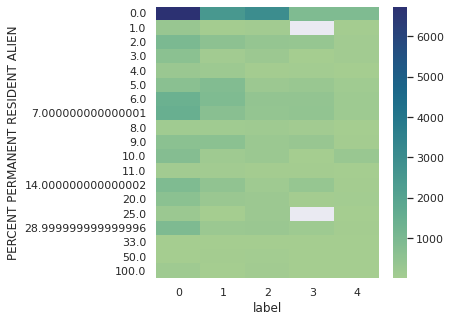

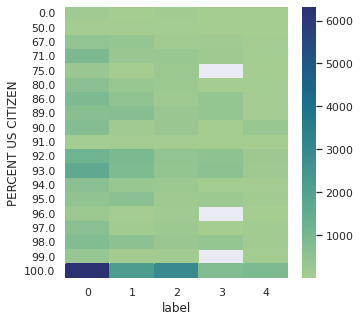

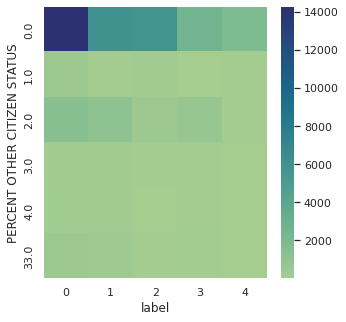

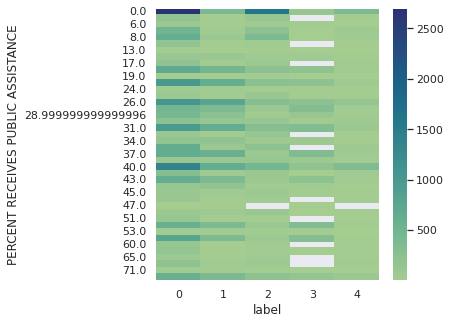

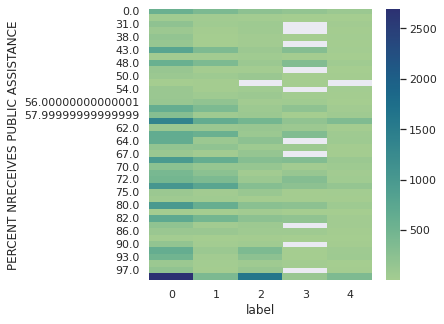

In [109]:
cols = df_encoded.columns
cols = cols.drop(['Docket Number ','Latitude','Longitude','BOROUGH_BRONX','BOROUGH_MANHATTAN','BOROUGH_QUEENS','BOROUGH_STATEN ISLAND', \
                  'BOROUGH_BROOKLYN'])

for i in range(5):
  df['label count'].loc[df['label'] == i] = df['label'].value_counts().tolist()[i]

print(df['label count'].value_counts())

for col in cols:
  things = df.groupby(by=[col, 'label']).count()['label count'].unstack()
  plt.figure(figsize=[5,5])
  sns.heatmap(things, cmap='crest')

In [198]:
things = df.groupby(by=['PERCENT FEMALE', 'label']).count()['PERCENT MALE'].unstack()
sns.heatmap(things, cmap='crest')

for i in range(5):
  df['label count'].loc[df['label'] == i] = df['label'].value_counts().tolist()[i]